In [17]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os 
import math
np.random.seed(1)

In [18]:
def sigmoid(x):
    return 1/(1+np.exp(-x+0.5))

def psigmoid(x):
    a = sigmoid(x)
    return a*(1 - a)

def ppsigmoid(x):
    a = sigmoid(x)
    return a - 3*a**2 + 2*a**3

def LeapFct(X,sets,coefs):
    p_sets = len(sets)
    parities = np.zeros((X.shape[0],p_sets))
    for j in range(p_sets):
        curr = np.ones(X.shape[0])
        for s in range(len(sets[j])):
            curr = curr*X[:,sets[j][s]]
        parities[:,j] = curr*coefs[j]
    return np.sum(parities,axis = 1)/ p_sets

def SquaredLoss(ytest,yhat_test):
    return np.mean((ytest - yhat_test)**2)

def randomRademacher(n,d):
    return 2*np.random.randint(2, size=(n,d))-1

def randomSecondLayer(N):
    return np.random.uniform(-1,1,N)

In [19]:
def smooth(v,ll):
    if ll == 0:
        return v
    ss = len(v)
    rr = np.copy(v)
    for i in range(ss):
        rr[i] = np.mean(v[max(0,i -ll):min(ss,i+ll)])
    return rr

In [20]:
def loss_train(y,f):
    return (y - f)**2 + (y - f)**3 +(y-f)**4

def loss_derivative(y,f):
    return 2*(y - f) + 3*(y - f)**2 + 4*(y-f)**3

def loss1_train(y,f):
    return (y - f)**2 + np.abs(y - f)**3 

def loss1_derivative(y,f):
    return 2*(y - f) + 3*np.sign(y-f)*(y - f)**2 

def squared_loss(y,f):
    return (y-f)**2

def squared_loss_derivative(y,f):
  return 2*(y-f)

def loss_ellone(y,f):
    return np.abs(y-f)

def loss_ellone_derivative(y,f):
    return np.sign(y-f)

In [21]:
def NNevaluation(W,a,X,N):
    Z = np.matmul(X,W.transpose())
    sigZ = sigmoid(Z)
    return np.matmul(sigZ,a)/N

def EvalError(W,a,mtest,N,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    ytest = LeapFct(Xtest,sets,coefs)
    yhat_test = NNevaluation(W,a,Xtest,N)
    return SquaredLoss(ytest,yhat_test)

def gradient_sq_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, squared_loss_derivative(ytrain,yMF))/mtrain]

def gradient_ellone_loss(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss_ellone_derivative(ytrain,yMF))/mtrain]

def gradient_loss1(W,a,N,mtrain,P,d,sets,coefs):
    Xtrain = randomRademacher(mtrain,d)
    ytrain = LeapFct(Xtrain,sets,coefs)
    Z = np.matmul(W, Xtrain.transpose())
    sigZ = sigmoid(Z)
    psigZ = psigmoid(Z)
    yMF = NNevaluation(W,a,Xtrain,N)
    return [np.matmul(a.reshape(N,1)*psigZ*loss1_derivative(ytrain,yMF),Xtrain)/mtrain,np.matmul(sigZ, loss1_derivative(ytrain,yMF))/mtrain]


def evaluateFourierCoeff(W,a,N,mtest,P,d,sets,coefs):
    Xtest = randomRademacher(mtest,d)
    yMF = NNevaluation(W,a,Xtest,N)
    p_sets = len(sets)
    parities = np.zeros((mtest,p_sets))
    for j in range(p_sets):
        curr = np.ones(mtest)
        for s in range(len(sets[j])):
            curr = curr*Xtest[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/mtest

In [22]:
def createXtot(P):
    Xtot = np.zeros((2**P,P))
    for i in range(2**P):
        Xtot[i,:] = np.array(list(np.binary_repr(i, width=P)))
    return 2*Xtot-1

In [23]:
def pexMSPEvalError(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    ytest = LeapFct(Xtot,sets,coefs)
    yhat_test = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return SquaredLoss(ytest,yhat_test)

def pexMSPNNevaluation(U,a,s,Xtot,mx,Nu,mG):
    G = np.random.normal(0,1,mG)
    Z = np.matmul(Xtot,U.transpose()).reshape(mx,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((mx,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2)
    return np.matmul(sigZ,a)/Nu

def pexMSPgradientloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientsqloss(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*squared_loss_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,squared_loss_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, squared_loss_derivative(ytrain,yMF))/2**P]

def pexMSPgradientloss1(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss1_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss1_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss1_derivative(ytrain,yMF))/2**P]

def pexMSPgradientlossellone(U,a,s,Xtot,mG,Nu,P,d,sets,coefs):
    G = np.random.normal(0,1,mG)
    ytrain = LeapFct(Xtot,sets,coefs)
    Z = np.matmul(Xtot,U.transpose()).reshape(2**P,Nu,1) + s.reshape(1,Nu,1)*(np.zeros((2**P,Nu,1)) + G.reshape(1,1,mG))
    sigZ = np.mean(sigmoid(Z),axis=2).transpose()
    psigZ = np.mean(psigmoid(Z),axis=2).transpose()
    psigZ2 = np.mean(psigmoid(Z)*G.reshape(1,1,mG),axis=2).transpose()
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    return [np.matmul(a.reshape(Nu,1)*psigZ*loss_ellone_derivative(ytrain,yMF),Xtot)/2**P,np.matmul(sigZ,loss_ellone_derivative(ytrain,yMF))/2**P,a*np.matmul(psigZ2, loss_ellone_derivative(ytrain,yMF))/2**P]

def pexMSPevaluateFourierCoeff(U,a,s,Xtot,mG,Nu,P,sets,coefs):
    yMF = pexMSPNNevaluation(U,a,s,Xtot,2**P,Nu,mG)
    p_sets = len(sets)
    parities = np.zeros((2**P,p_sets))
    for j in range(p_sets):
        curr = np.ones(2**P)
        for s in range(len(sets[j])):
            curr = curr*Xtot[:,sets[j][s]]
        parities[:,j] = curr/coefs[j]
    return np.matmul(parities.transpose(),yMF)/2**P

In [24]:
P = 3
uuu = [[0,1,2]]
ccc = [1]
mmm = len(uuu)
T=2500
KK=10
d1=100
d2=300
d3=500

In [25]:
d = d1
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF11 = np.zeros((KK,T))

TrackLossSGD11 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD11[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF11[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 == 0:
         print(kk,t, TrackLossDF11[kk,t], TrackLossSGD11[kk,t])

0 0 1.0005954088577158 1.003968402756632
0 500 1.000000000013463 0.00013056596877344742
0 1000 1.0000000000272813 3.331080117456162e-05
0 1500 1.0000000003977978 2.5215333553460055e-05
0 2000 1.000000000160686 1.9081588810644755e-05
1 0 1.0102047572769863 1.000367390669585
1 500 1.0000000003940712 0.0012706483569177214
1 1000 1.0000000020805335 5.6873271188882036e-05
1 1500 1.000000000118943 3.5346655007083576e-05
1 2000 1.0000000049568385 3.1453052747468006e-05
2 0 1.00000033229461 0.9986407057012081
2 500 1.0000000000002112 0.00017637927649409604
2 1000 1.0000000000000182 7.08328791485255e-05
2 1500 1.0000000000000024 4.079676405806979e-05
2 2000 0.9999999999999999 3.2487566684793236e-05
3 0 1.0004384589239494 0.998642411057737
3 500 1.0000000013184114 9.455360662120001e-05
3 1000 1.0000000000037206 1.453275519919586e-05
3 1500 1.000000000838242 9.234289063421343e-06
3 2000 1.00000000015019 7.550956262062202e-06
4 0 1.0000225205601228 0.9980465574153788
4 500 1.00000000004826 0.00036

In [26]:
d =d2
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF12 = np.zeros((KK,T))
TrackLossSGD12 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD12[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF12[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 ==0:
         print(kk,t,TrackLossDF12[kk,t], TrackLossSGD12[kk,t])

0 0 1.000005269193999 1.0013240466416664
0 500 1.0000000000011173 1.004219333028729
0 1000 1.0000000000026783 0.0006387656484439848
0 1500 1.000000000000001 8.08225051141859e-05
0 2000 1.0000000000088507 6.472293594879012e-05
1 0 1.0014837784079405 1.0014493956212387
1 500 1.0000000009599197 1.0002685914435434
1 1000 1.000000001118324 0.009512698781077963
1 1500 1.0000000003037333 0.0001262808547244146
1 2000 1.0000000003938625 7.40515346601685e-05
2 0 1.0010775631175162 0.9983966438551078
2 500 1.000000000348809 1.017932913492949
2 1000 1.0000000001542277 1.0019488065569762
2 1500 1.000000000158419 0.0018291927892848988
2 2000 1.0000000000563798 0.0001496642848209162
3 0 1.0001590027197067 0.9987771057146619
3 500 1.0000000001146438 0.9980883176436366
3 1000 1.0000000000080114 0.012683134261567003
3 1500 1.000000000004906 0.00021909265381314422
3 2000 1.0000000000584666 0.0001308660371642486
4 0 1.0010426969833306 0.9980869485744934
4 500 1.0000000060198513 0.9831330443057807
4 1000 1

In [27]:
d = d3
xi = 0.5
eta_w =  xi
eta_a =  xi

Xtot = createXtot(P)
Nu = 50
mG = 100
    
N = 300
mtest = 300
mtrain = d

TrackLossDF13 = np.zeros((KK,T))

TrackLossSGD13 = np.zeros((KK,T))

for kk in range(KK):
    
    at_DF = randomSecondLayer(Nu)
    Ut_DF = 0*randomRademacher(Nu,P)/np.sqrt(d)
    st_DF = np.ones(Nu)

    at_SGD = randomSecondLayer(N)
    Wt_SGD = randomRademacher(N,d)/np.sqrt(d)

    for t in range(T):
        TrackLossSGD13[kk,t] = EvalError(Wt_SGD,at_SGD,mtest,N,P,d,uuu,ccc)
        
        [GW,Ga] = gradient_loss1(Wt_SGD,at_SGD,N,mtrain,P,d,uuu,ccc)
        Wt_SGD = Wt_SGD + eta_w*GW
        at_SGD = at_SGD + eta_a*Ga
        
        TrackLossDF13[kk,t] = pexMSPEvalError(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        
        [GUDF,GaDF,GsDF] = pexMSPgradientloss1(Ut_DF,at_DF,st_DF,Xtot,mG,Nu,P,d,uuu,ccc)
        Ut_DF = Ut_DF + eta_w*GUDF
        at_DF = at_DF + eta_a*GaDF
        st_DF = st_DF + eta_w*GsDF
        if t%500 == 0:
         print(kk,t,TrackLossDF13[kk,t], TrackLossSGD13[kk,t])

0 0 1.001853429753818 1.0025046505614335
0 500 1.0000000001172946 1.0060815188987304
0 1000 1.0000000002057892 0.9987847322909573
0 1500 1.0000000002772393 0.2412441790929198
0 2000 1.0000000000009526 0.0001385882550382243
1 0 1.0001472173033557 1.0003444247054123
1 500 1.000000000066805 1.0027600809279769
1 1000 1.0000000016671056 0.9993728651256255
1 1500 1.0000000026495477 0.14206504094970546
1 2000 1.0000000001792415 0.00021204224515596412
2 0 1.0002569364683311 1.0011688863821098
2 500 1.000000000519138 1.0021799206904127
2 1000 1.0000000003748875 0.00231125265084902
2 1500 1.0000000001777534 0.00011832091936388035
2 2000 1.0000000001822398 6.415592167508776e-05
3 0 1.0032353961692837 0.9980091669128099
3 500 1.000000000361711 0.9978706235725866
3 1000 1.0000000009105827 1.00694815779831
3 1500 1.0000000000354234 0.9538268045498209
3 2000 1.0000000006425378 0.0005843352551418029
4 0 1.0001775534410182 1.0015212887428586
4 500 1.00000000044774 1.0014390197463072
4 1000 1.0000000005

In [28]:
meanLossDF11 =  np.mean(TrackLossDF11,axis = 0)

meanLoss11 = np.mean(TrackLossSGD11,axis = 0)
stdLoss11 = np.std(TrackLossSGD11,axis = 0)/np.sqrt(KK)


In [29]:
meanLossDF12 =  np.mean(TrackLossDF12,axis = 0)

meanLoss12 = np.mean(TrackLossSGD12,axis = 0)
stdLoss12 = np.std(TrackLossSGD12,axis = 0)/np.sqrt(KK)


In [30]:
meanLossDF13 = np.mean(TrackLossDF13,axis = 0)

meanLoss13 = np.mean(TrackLossSGD13,axis = 0)
stdLoss13 = np.std(TrackLossSGD13,axis = 0)/np.sqrt(KK)

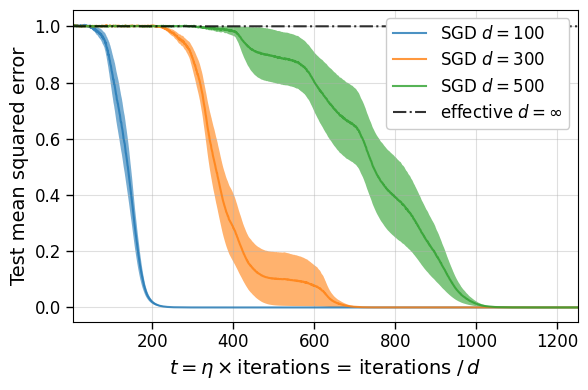

In [31]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})
ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)
   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label=r'effective $d=\infty$')


ax.grid(alpha=0.4)
ax.set_xlabel(r'$t = \eta \times $iterations = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='upper right', fontsize=12, framealpha = 1)
ax.set_xlim([3,xi*T])


fig.tight_layout()
plt.savefig('ell3loss/ell3parity.pdf')
plt.show()

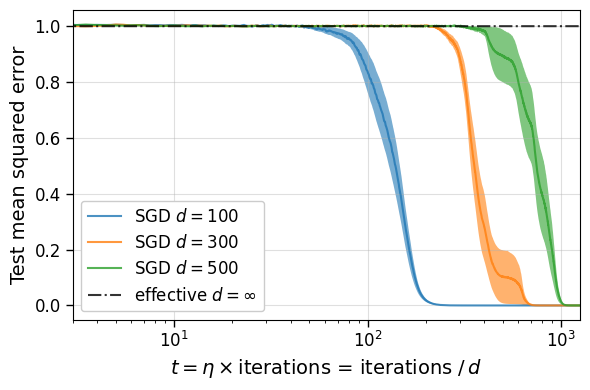

In [33]:
fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))#, gridspec_kw={'width_ratios': [1.5, 2]})

ax.plot(xi*np.arange(T),smooth(meanLoss11,1), linestyle='-', alpha = 0.8, label=r'SGD $d=100$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss11 - stdLoss11,4), smooth(meanLoss11 + stdLoss11,4),  alpha = 0.6)

ax.plot(xi*np.arange(T),smooth(meanLoss12,1), linestyle='-', alpha = 0.8, label=r'SGD $d=300$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss12 - stdLoss12,4), smooth(meanLoss12 + stdLoss12,4),  alpha = 0.6)


ax.plot(xi*np.arange(T),smooth(meanLoss13,1), linestyle='-', alpha = 0.8, label=r'SGD $d=500$')
ax.fill_between(xi*np.arange(T),smooth(meanLoss13 - stdLoss13,4), smooth(meanLoss13 + stdLoss13,4),  alpha = 0.6)
   
ax.plot(xi*np.arange(T),smooth(meanLossDF11,5), color ='black', alpha = 0.8,linestyle='-.', label=r'effective $d=\infty$')


ax.grid(alpha=0.4)
ax.set_xlabel(r'$t=\eta \times $iterations = iterations $/\,d$', fontsize =14)
ax.set_ylabel(r'Test mean squared error', fontsize =14)
plt.setp(ax.get_xticklabels(),fontsize=12)
plt.setp(ax.get_yticklabels(),fontsize=12)
ax.tick_params(direction='out', length=5, width=1)
ax.legend(loc='lower left', fontsize=12, framealpha = 1)
ax.set_xscale('log')
ax.set_xlim([3,xi*T])


fig.tight_layout()
plt.savefig('ell3loss/ell3parity-log.pdf')
plt.show()